# Imports

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
%matplotlib inline

import time
# start_time = time.time()
# # main()
# print("--- %s seconds ---" % (time.time() - start_time))

c:\users\admin\appdata\local\programs\python\python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Data and preprocessing and miscellaneous functions

use mnist_train.csv as our training data and mnist_test.csv as our validation set
http://pjreddie.com/projects/mnist-in-csv/

In [2]:
start_time = time.time()
train_set = pd.read_csv('mnist_train.csv',header=None)
test_set = pd.read_csv('mnist_test.csv',header=None)
print("--- %s seconds ---" % (time.time() - start_time))

--- 5.92461085319519 seconds ---


In [3]:
new_df = pd.DataFrame(columns = ['modules','time_used/sec',])

start_time = time.time()

train_set = pd.read_csv('mnist_train.csv',header=None)
test_set = pd.read_csv('mnist_test.csv',header=None)
print("--- %s seconds ---" % (time.time() - start_time))
new_df.loc[len(new_df)] = ["preprocess",(time.time() - start_time)]


--- 6.690660238265991 seconds ---


In [4]:
# test_set = test_set[:5]
# train_set = train_set[:5]
train_set.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
start_time = time.time()

#get labels in own array
train_lb=np.array(train_set[0])
test_lb=np.array(test_set[0])

#one hot encode the labels
train_lb=(np.arange(10) == train_lb[:,None]).astype(np.float32)
test_lb=(np.arange(10) == test_lb[:,None]).astype(np.float32)

#drop the labels column from training dataframe
trainX=train_set.drop(0,axis=1)
testX=test_set.drop(0,axis=1)

#put in correct float32 array format
trainX=np.array(trainX).astype(np.float32)
testX=np.array(testX).astype(np.float32)
print("--- %s seconds ---" % (time.time() - start_time))
new_df.loc[len(new_df)] = ["preprocess",(time.time() - start_time)]


--- 0.6712021827697754 seconds ---


In [12]:
start_time = time.time()

#reformat the data so it's not flat
trainX=trainX.reshape(len(trainX),28,28,1)
testX = testX.reshape(len(testX),28,28,1)
print("--- %s seconds ---" % (time.time() - start_time))
new_df.loc[len(new_df)] = ["reformat the data",(time.time() - start_time)]


--- 0.0009992122650146484 seconds ---


In [13]:
start_time = time.time()

#get a validation set and remove it from the train set
trainX,valX,train_lb,val_lb=trainX[0:(len(trainX)-500),:,:,:],trainX[(len(trainX)-500):len(trainX),:,:,:],\
                            train_lb[0:(len(trainX)-500),:],train_lb[(len(trainX)-500):len(trainX),:]
print("--- %s seconds ---" % (time.time() - start_time))
new_df.loc[len(new_df)] = ["get a validation",(time.time() - start_time)]


--- 0.025929927825927734 seconds ---


--- 0.04089021682739258 seconds ---


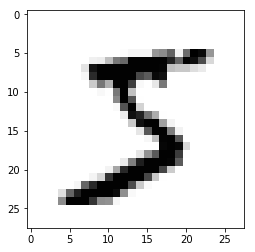

In [14]:
start_time = time.time()

#make sure the images are alright
plt.imshow(trainX.reshape(len(trainX),28,28)[0],cmap="Greys")
print("--- %s seconds ---" % (time.time() - start_time))

In [15]:
start_time = time.time()

#need to batch the test data because running low on memory
class test_batchs:
    def __init__(self,data):
        self.data = data
        self.batch_index = 0
    def nextBatch(self,batch_size):
        if (batch_size+self.batch_index) > self.data.shape[0]:
            print ("batch sized is messed up")
        batch = self.data[self.batch_index:(self.batch_index+batch_size),:,:,:]
        self.batch_index= self.batch_index+batch_size
        return batch

#set the test batchsize
test_batch_size = 100
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.0 seconds ---


In [16]:
start_time = time.time()

#returns accuracy of model
def accuracy(target,predictions):
    return(100.0*np.sum(np.argmax(target,1) == np.argmax(predictions,1))/target.shape[0])
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.0 seconds ---


In [17]:
#use os to get our current working directory so we can save variable
file_path = os.getcwd()+'/model.ckpt'

# Google Inception modules

In [23]:
batch_size = 48
map1 = 32
map2 = 64
num_fc1 = 700 #1028
num_fc2 = 10
reduce1x1 = 16
dropout=0.5

graph = tf.Graph()
with graph.as_default():
    #train data and labels
    X = tf.placeholder(tf.float32,shape=(batch_size,28,28,1))
    y_ = tf.placeholder(tf.float32,shape=(batch_size,10))
    
    #validation data
    tf_valX = tf.placeholder(tf.float32,shape=(len(valX),28,28,1))
    
    #test data
    tf_testX=tf.placeholder(tf.float32,shape=(test_batch_size,28,28,1))
    
    def createWeight(size,Name):
        return tf.Variable(tf.truncated_normal(size, stddev=0.1),
                          name=Name)
    
    def createBias(size,Name):
        return tf.Variable(tf.constant(0.1,shape=size),
                          name=Name)
    
    def conv2d_s1(x,W):
        return tf.nn.conv2d(x,W,strides=[1,1,1,1],padding='SAME')
    
    def max_pool_3x3_s1(x):
        return tf.nn.max_pool(x,ksize=[1,3,3,1],
                             strides=[1,1,1,1],padding='SAME')
    
    
    #Inception Module1
    #
    #follows input
    W_conv1_1x1_1 = createWeight([1,1,1,map1],'W_conv1_1x1_1')
    b_conv1_1x1_1 = createWeight([map1],'b_conv1_1x1_1')
    
    #follows input
    W_conv1_1x1_2 = createWeight([1,1,1,reduce1x1],'W_conv1_1x1_2')
    b_conv1_1x1_2 = createWeight([reduce1x1],'b_conv1_1x1_2')
    
    #follows input
    W_conv1_1x1_3 = createWeight([1,1,1,reduce1x1],'W_conv1_1x1_3')
    b_conv1_1x1_3 = createWeight([reduce1x1],'b_conv1_1x1_3')
    
    #follows 1x1_2
    W_conv1_3x3 = createWeight([3,3,reduce1x1,map1],'W_conv1_3x3')
    b_conv1_3x3 = createWeight([map1],'b_conv1_3x3')
    
    #follows 1x1_3
    W_conv1_5x5 = createWeight([5,5,reduce1x1,map1],'W_conv1_5x5')
    b_conv1_5x5 = createBias([map1],'b_conv1_5x5')
    
    #follows max pooling
    W_conv1_1x1_4= createWeight([1,1,1,map1],'W_conv1_1x1_4')
    b_conv1_1x1_4= createWeight([map1],'b_conv1_1x1_4')
    
    
    
    #Inception Module2
    #
    #follows inception1
    W_conv2_1x1_1 = createWeight([1,1,4*map1,map2],'W_conv2_1x1_1')
    b_conv2_1x1_1 = createWeight([map2],'b_conv2_1x1_1')
    
    #follows inception1
    W_conv2_1x1_2 = createWeight([1,1,4*map1,reduce1x1],'W_conv2_1x1_2')
    b_conv2_1x1_2 = createWeight([reduce1x1],'b_conv2_1x1_2')
    
    #follows inception1
    W_conv2_1x1_3 = createWeight([1,1,4*map1,reduce1x1],'W_conv2_1x1_3')
    b_conv2_1x1_3 = createWeight([reduce1x1],'b_conv2_1x1_3')
    
    #follows 1x1_2
    W_conv2_3x3 = createWeight([3,3,reduce1x1,map2],'W_conv2_3x3')
    b_conv2_3x3 = createWeight([map2],'b_conv2_3x3')
    
    #follows 1x1_3
    W_conv2_5x5 = createWeight([5,5,reduce1x1,map2],'W_conv2_5x5')
    b_conv2_5x5 = createBias([map2],'b_conv2_5x5')
    
    #follows max pooling
    W_conv2_1x1_4= createWeight([1,1,4*map1,map2],'W_conv2_1x1_4')
    b_conv2_1x1_4= createWeight([map2],'b_conv2_1x1_4')
    
    

    #Fully connected layers
    #since padding is same, the feature map with there will be 4 28*28*map2
    W_fc1 = createWeight([28*28*(4*map2),num_fc1],'W_fc1')
    b_fc1 = createBias([num_fc1],'b_fc1')
    
    W_fc2 = createWeight([num_fc1,num_fc2],'W_fc2')
    b_fc2 = createBias([num_fc2],'b_fc2')

    def model(x,train=True):
        #Inception Module 1
        
        start_time = time.time()
        conv1_1x1_1 = conv2d_s1(x,W_conv1_1x1_1)+b_conv1_1x1_1
        new_df.loc[len(new_df)] = ['conv1_1x1_1',(time.time() - start_time)]
        
        start_time = time.time()
        conv1_1x1_2 = tf.nn.relu(conv2d_s1(x,W_conv1_1x1_2)+b_conv1_1x1_2)
        new_df.loc[len(new_df)] = ['conv1_1x1_2',(time.time() - start_time)]
        
        start_time = time.time()
        conv1_1x1_3 = tf.nn.relu(conv2d_s1(x,W_conv1_1x1_3)+b_conv1_1x1_3)
        new_df.loc[len(new_df)] = ['conv1_1x1_3' ,(time.time() - start_time)]
        
        start_time = time.time()
        conv1_3x3 = conv2d_s1(conv1_1x1_2,W_conv1_3x3)+b_conv1_3x3
        new_df.loc[len(new_df)] = ['conv1_3x3' ,(time.time() - start_time)]
        
        start_time = time.time()
        conv1_5x5 = conv2d_s1(conv1_1x1_3,W_conv1_5x5)+b_conv1_5x5
        new_df.loc[len(new_df)] = ['conv1_5x5' ,(time.time() - start_time)]
        
        start_time = time.time()
        maxpool1 = max_pool_3x3_s1(x)
        new_df.loc[len(new_df)] = ['maxpool1' ,(time.time() - start_time)]
        
        start_time = time.time()
        conv1_1x1_4 = conv2d_s1(maxpool1,W_conv1_1x1_4)+b_conv1_1x1_4
        new_df.loc[len(new_df)] = ['conv1_1x1_4' ,(time.time() - start_time)]
        
        #concatenate all the feature maps and hit them with a relu
        inception1 = tf.nn.relu(tf.concat([conv1_1x1_1,conv1_3x3,conv1_5x5,conv1_1x1_4],3))

        
        #Inception Module 2
        start_time = time.time()
        conv2_1x1_1 = conv2d_s1(inception1,W_conv2_1x1_1)+b_conv2_1x1_1
        new_df.loc[len(new_df)] = ['conv2_1x1_1' ,(time.time() - start_time)]
        
        start_time = time.time()
        conv2_1x1_2 = tf.nn.relu(conv2d_s1(inception1,W_conv2_1x1_2)+b_conv2_1x1_2)
        new_df.loc[len(new_df)] = ['conv2_1x1_2' ,(time.time() - start_time)]
        
        start_time = time.time()
        conv2_1x1_3 = tf.nn.relu(conv2d_s1(inception1,W_conv2_1x1_3)+b_conv2_1x1_3)
        new_df.loc[len(new_df)] = ['conv2_1x1_3' ,(time.time() - start_time)]
        
        start_time = time.time()
        conv2_3x3 = conv2d_s1(conv2_1x1_2,W_conv2_3x3)+b_conv2_3x3
        new_df.loc[len(new_df)] = ['conv2_3x3' ,(time.time() - start_time)]
        
        start_time = time.time()
        conv2_5x5 = conv2d_s1(conv2_1x1_3,W_conv2_5x5)+b_conv2_5x5
        new_df.loc[len(new_df)] = ['conv2_5x5' ,(time.time() - start_time)]
        
        start_time = time.time()
        maxpool2 = max_pool_3x3_s1(inception1)
        new_df.loc[len(new_df)] = ['maxpool2' ,(time.time() - start_time)]
        
        start_time = time.time()
        conv2_1x1_4 = conv2d_s1(maxpool2,W_conv2_1x1_4)+b_conv2_1x1_4
        new_df.loc[len(new_df)] = ['conv2_1x1_4' ,(time.time() - start_time)]
        
        #concatenate all the feature maps and hit them with a relu
        start_time = time.time()
        inception2 = tf.nn.relu(tf.concat([conv2_1x1_1,conv2_3x3,conv2_5x5,conv2_1x1_4],3))
        new_df.loc[len(new_df)] = ['inception2' ,(time.time() - start_time)]

        #flatten features for fully connected layer
        start_time = time.time()
        inception2_flat = tf.reshape(inception2,[-1,28*28*4*map2])
        new_df.loc[len(new_df)] = ['inception2_flat' ,(time.time() - start_time)]
        
        #Fully connected layers
        if train:
            h_fc1 =tf.nn.dropout(tf.nn.relu(tf.matmul(inception2_flat,W_fc1)+b_fc1),dropout)
        else:
            h_fc1 = tf.nn.relu(tf.matmul(inception2_flat,W_fc1)+b_fc1)

        return tf.matmul(h_fc1,W_fc2)+b_fc2
    
#     tf.nn.softmax_cross_entropy_with_logits(logits = yPredbyNN, labels=Y)
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits=model(X),labels=y_))
    opt = tf.train.AdamOptimizer(1e-4).minimize(loss)
    
    predictions_val = tf.nn.softmax(model(tf_valX,train=False))
    predictions_test = tf.nn.softmax(model(tf_testX,train=False))
    
    #initialize variable
    init = tf.initialize_all_variables()
    
    #use to save variables so we can pick up later
    saver = tf.train.Saver()

In [ ]:
num_steps = 20000
sess = tf.Session(graph=graph)

#initialize variables
sess.run(init)
print("Model initialized.")

#set use_previous=1 to use file_path model
#set use_previous=0 to start model from scratch
use_previous = 0

#use the previous model or don't and initialize variables
if use_previous:
    saver.restore(sess,file_path)
    print("Model restored.")

#training
for s in range(num_steps):
    start_time = time.time()

    offset = (s*batch_size) % (len(trainX)-batch_size)
    batch_x,batch_y = trainX[offset:(offset+batch_size),:],train_lb[offset:(offset+batch_size),:]
    feed_dict={X : batch_x, y_ : batch_y}
    _,loss_value = sess.run([opt,loss],feed_dict=feed_dict)
    
    print("step",s)
    print("--- %s seconds ---" % (time.time() - start_time))
#     new_entry = {'time_used/sec': 'device1', 'months': 'month1'}
#     new_df = pd.concat([new_df, "step", axis=0)
#     new_df.loc[len(new_df)] = ['step {}'.format(s) ,(time.time() - start_time)]
    
    
    if s%100 == 0:
        feed_dict = {tf_valX : valX}
        preds=sess.run(predictions_val,feed_dict=feed_dict)
        
        print ("step: "+str(s))
        print ("validation accuracy: "+str(accuracy(val_lb,preds)))
        print (" ")
        print("--- %s seconds ---" % (time.time() - start_time))

        
    #get test accuracy and save model
    if s == (num_steps-1):
        #create an array to store the outputs for the test
        result = np.array([]).reshape(0,10)

        #use the batches class
        batch_testX=test_batchs(testX)

        for i in range(len(testX)/test_batch_size):
            feed_dict = {tf_testX : batch_testX.nextBatch(test_batch_size)}
            preds=sess.run(predictions_test, feed_dict=feed_dict)
            result=np.concatenate((result,preds),axis=0)
        
        print ("test accuracy: "+str(accuracy(test_lb,result)))
        
        save_path = saver.save(sess,file_path)
        print("Model saved.")
sess.close()       

Model initialized.


In [22]:
new_df

,modules,time_used/sec
0,preprocess,6.691655
1,preprocess,1.015813
2,reformat the data,0.000992
3,get a validation,0.000000
4,preprocess,0.671202
5,reformat the data,0.000999
6,get a validation,0.025930
7,conv1_1x1_1,0.000997
8,conv1_1x1_2,0.000998
9,conv1_1x1_3,0.001994
